# Training a ConvNet PyTorch

In this notebook, you'll learn how to use the powerful PyTorch framework to specify a conv net architecture and train it on the human action recognition dataset. 


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T
import timeit
from PIL import Image
import os
import numpy as np
import scipy.io
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

First, load the labels of the dataset, you should write your path of the hw6_data.mat file.

In [2]:
label_mat=scipy.io.loadmat('./data/hw6_data.mat')
label_train=label_mat['trLb']
print(len(label_train))
label_val=label_mat['valLb']
print(len(label_val))

7770
2230


In [3]:
class ActionDataset(Dataset):
    """Action dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            labels(list): labels if images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels
    def __len__(self):
        return self.length*3

    def __getitem__(self, idx):
        
        folder=int(idx/3)+1
        imidx=idx%3+1
        folder=format(folder,'05d')
        imgname=str(imidx)+'.jpg'
        img_path = os.path.join(self.root_dir,
                                folder,imgname)
        image = Image.open(img_path)
        if len(self.labels)!=0:
            Label=self.labels[int(idx/3)][0]-1
        if self.transform:
            image = self.transform(image)
        if len(self.labels)!=0:
            sample={'image':image,'img_path':img_path,'Label':Label}
        else:
            sample={'image':image,'img_path':img_path}
        return sample

Iterating over the dataset by a for loop.

In [ ]:
image_dataset=ActionDataset(root_dir='./data/trainClips/', labels=label_train,transform=train_tf)

#iterating though the dataset
for i in range(7770*3):
    sample=image_dataset[i]
    print(sample['image'])
    break
    #print('\n********')
    #print(sample['image'].shape)
    #if i%300 == 0:
    #    sample=image_dataset[i]
    #    print(int(i/3), sample['Label'])
    #print(sample['img_path'])

We can iterate over the created dataset with a 'for' loop as before. However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. 

In [ ]:
image_dataloader = DataLoader(image_dataset, batch_size=4,shuffle=True, num_workers=4)

for i,sample in enumerate(image_dataloader):
    #print(i, sample['image'].shape, '|', sample['img_path'], '|', sample['Label'])
    print()
    print(i, sample['image'][0, 0, 0, 0])
    if i>1: 
        break

Dataloaders for the training, validationg and testing set. 

In [5]:
image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)
image_dataloader_train = DataLoader(image_dataset_train, batch_size=32, shuffle=True, num_workers=4)

image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)
image_dataloader_val = DataLoader(image_dataset_val, batch_size=32, shuffle=False, num_workers=4)

image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform=train_tf)
image_dataloader_test = DataLoader(image_dataset_test, batch_size=32, shuffle=False, num_workers=4)

In [28]:
dtype = torch.FloatTensor # the CPU datatype
# Constant to control how frequently we print train loss
print_every = 100
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

## Example Model

### Some assorted tidbits

Let's start by looking at a simple model. First, note that PyTorch operates on Tensors, which are n-dimensional arrays functionally analogous to numpy's ndarrays, with the additional feature that they can be used for computations on GPUs.

We'll provide you with a Flatten function, which we explain here. Remember that our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:
* N is the number of datapoints
* C is the number of image channels. 
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input  data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector. The Flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [29]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in PyTorch -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up.  nn.Sequential is a container which applies each layer
one after the other.

In this example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Cross-Entropy loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 10092 and 10.


In [9]:
# Here's where we define the architecture of the model... 
simple_model = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                Flatten(), # see above for explanation
                nn.Linear(10092, 10), # affine layer
              )

# Set the type of all data in this model to be FloatTensor 
simple_model.type(dtype)

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(simple_model.parameters(), lr=1e-2) # lr sets the learning rate of the optimizer

PyTorch supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers: http://pytorch.org/docs/nn.html
* Activations: http://pytorch.org/docs/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/optim.html#algorithms

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the PyTorch documentation and configuring your own model. 

Using the code provided above as guidance, and using the following PyTorch documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 8 filters and stride of 1
* ReLU Activation Layer
* 2x2 Max Pooling layer with a stride of 2
* 7x7 Convolutional Layer with 16 filters and stride of 1
* ReLU Activation Layer
* 2x2 Max Pooling layer with a stride of 2
* Flatten the feature map
* ReLU Activation Layer
* Affine layer to map input units to 10 outputs, you need to figure out the input size here.


In [10]:
fixed_model_base = nn.Sequential( 
    #########1st TODO  (10 points)###################
    nn.Conv2d(3, 8, kernel_size=7, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 16, kernel_size=7, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.ReLU(),
    nn.Linear(16*11*11, 10)
    ####################################
            )
fixed_model = fixed_model_base.type(dtype)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 32 x 10, since our batches have size 32 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [11]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(32, 3, 64, 64).type(dtype)
x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
print(np.array(ans.size()))
np.array_equal(np.array(ans.size()), np.array([32, 10]))   

[32 10]


True

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the fixed_model_base we provided above).

Make sure you understand how each PyTorch function used below corresponds to what you implemented in your custom neural network implementation.

Note that because we are not resetting the weights anywhere below, if you run the cell multiple times, you are effectively training multiple epochs (so your performance should improve).

First, set up an RMSprop optimizer (using a 1e-4 learning rate) and a cross-entropy loss function:

In [12]:
################ 2nd TODO  (5 points)##################
optimizer = torch.optim.RMSprop(fixed_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# This sets the model in "training" mode. 
# This is relevant for some layers that may have different behavior
# in training mode vs testing mode, such as Dropout and BatchNorm. 
fixed_model.train()

# Load one batch at a time.
for t, sample in enumerate(image_dataloader_train):
    x_var = Variable(sample['image'])
    #print(type(x_var.data))
    #print(x_var.shape)
    y_var = Variable(sample['Label']).long()

    # This is the forward pass: predict the scores for each class, for each x in the batch.
    scores = fixed_model(x_var)
    
    # Use the correct y values and the predicted y values to compute the loss.
    loss = loss_fn(scores, y_var)
    
    if (t + 1) % print_every == 0:
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

    # Zero out all of the gradients for the variables which the optimizer will update.
    optimizer.zero_grad()
    
    # This is the backwards pass: compute the gradient of the loss with respect to each 
    # parameter of the model.
    loss.backward()
    
    # Actually update the parameters of the model using the gradients computed by the backwards pass.
    optimizer.step()

Now you've seen how the training process works in PyTorch. To save you writing boilerplate code, we're providing the following helper functions to help you train for multiple epochs and check the accuracy of your model:

In [14]:
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'])
            y_var = Variable(sample['Label'].long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'])
        y_var = sample['Label']
        #y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.max(1)#scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Check the accuracy of the model.

Let's see the train and check_accuracy code in action -- feel free to use these methods when evaluating the models you develop below.

You should get a training loss of around 1.0-1.2, and a validation accuracy of around 50-60%. As mentioned above, if you re-run the cells, you'll be training more epochs, so your performance will improve past these numbers.

But don't worry about getting these numbers better -- this was just practice before you tackle designing your own model.

In [ ]:
torch.random.manual_seed(12345)
fixed_model.cpu()
fixed_model.apply(reset) 
fixed_model.train() 
train(fixed_model, loss_fn, optimizer, image_dataloader_train, num_epochs=5) 
check_accuracy(fixed_model, image_dataloader_train)# check accuracy on the training set
check_accuracy(fixed_model, image_dataloader_val)#check accuracy on the validation set

### Don't forget the validation set!

And note that you can use the check_accuracy function to evaluate on the validation set, by passing **image_dataloader_val** as the second argument to check_accuracy. The accuracy on validation set is arround 40-50%.

In [100]:
check_accuracy(fixed_model, image_dataloader_val)#check accuracy on the validation set

Got 3712 / 6690 correct (55.49)


##### Train a better  model for action recognition!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition **validation** set. You can use the check_accuracy and train functions from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 55% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. 



#  My final model uses pretrained models from resnet18 and resnet34 

# Final model (version 0.6) = resnet18/resnet32 + full connect layer

In [17]:
###########3rd TODO (20 points, must submit the results to Kaggle) ##############
# Train your model here, and make sure the output of this cell is the accuracy of your best model on the 
# train, val, and test sets. Here's some code to get you started. The output of this cell should be the training
# and validation accuracy on your best model (measured by validation accuracy).


import torchvision.models as models
resnet18 = models.resnet18(pretrained=True).cuda()
resnet34 = models.resnet34(pretrained=True).cuda()

train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)
image_dataloader_train = DataLoader(image_dataset_train, batch_size=32, shuffle=True, num_workers=4)

image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)
image_dataloader_val = DataLoader(image_dataset_val, batch_size=32, shuffle=False, num_workers=4)

image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform=train_tf)
image_dataloader_test = DataLoader(image_dataset_test, batch_size=32, shuffle=False, num_workers=4)

model_fc = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 10)
)

device = torch.device('cuda')
model = model_fc.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)

Got 3723 / 6690 correct (55.65)


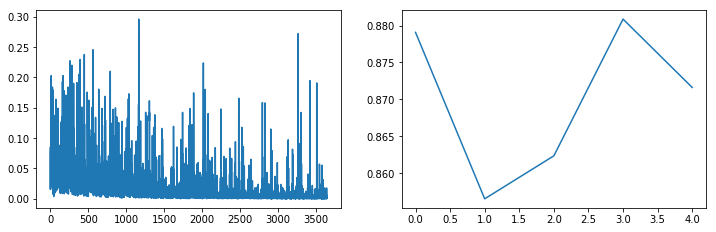

In [20]:
num_epochs = 5
train_losses = []
valid_accs = []
best_acc = 0
PATH = './best_model_{}.pt'

for epoch in range(num_epochs):
    for t, sample in enumerate(image_dataloader_train):
        model.train()
        x_var = Variable(sample['image'].cuda())
        y_var = Variable(sample['Label'].cuda().long())
        
        x_var = resnet18(x_var)
        #x_var = resnet34(x_var)
        scores = model(x_var)
        loss = loss_fn(scores, y_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    num_correct = 0
    num_samples = 0
    for t, sample in enumerate(image_dataloader_val):
        x_var = Variable(sample['image'].cuda())
        y_var = Variable(sample['Label'].cuda().long())
        
        x_var = resnet18(x_var)
        #x_var = resnet34(x_var)
        scores = model(x_var)
        
        _, preds = scores.data.cpu().max(1)
        y_var = y_var.cpu()
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    
    acc = float(num_correct)/num_samples
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)))
    
    valid_accs.append(acc)
    clear_output(True)
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.plot(train_losses)
    plt.subplot(222)
    plt.plot(valid_accs)
    plt.show()

### Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

## My models evolve from version 0.1 to version 0.6
### 4th TODO (5 points)

|Model|Kaggle Score| What I did |
|- | -| -|
|version 0.1|0.56106|The orginal model provided|
|version 0.2|0.59041|Add BatchNorm layer between Conv and ReLU. Change kernel_size=3|
|version 0.3|0.61661|Add weight_decay=0.5 in optimization|
|version 0.4|0.68858|Add 2 layers to 4 layers, BatchNorm before the fc, add padding=1 in max pool|
|version 0.5| No attempt|data augmentation, global average pooling and dropout | 
|version 0.6|0.83771|Use pretrained resnet18/resnet32 plus full connection layer|

|Label|Meaning|
| -- | -- |
| 0 | band marching|
| 1 | bowling |
| 2 | diving |
| 3 | hammer throw |
| 4 | juggling balls |
| 5 | nun chunks |
| 6 | drumming |
| 7 | rowing |
| 8 | still rings |
| 9 | uneven bars |


### Testing the model and submit on Kaggle
Testing the model on the testing set and save the results as a .csv file. 
Please submitted the results.csv file generated by predict_on_test() to Kaggle(https://www.kaggle.com/c/cse512springhw3) to see how well your network performs on the test set. 
#######5th TODO (submit the result to Kaggle, the highest 3 entries get extra 10 points )###############

## Kaggle score = 0.83771

### GPU! (This part is optional, 0 points)

If you have access to GPU, you can make the code run on GPU, it would be much faster. 

Now, we're going to switch the dtype of the model and our data to the GPU-friendly tensors, and see what happens... everything is the same, except we are casting our model and input tensors as this new dtype instead of the old one.

If this returns false, or otherwise fails in a not-graceful way (i.e., with some error message), you may not have an NVIDIA GPU available on your machine. 

In [272]:
gpu_dtype = torch.cuda.FloatTensor

fixed_model_gpu = copy.deepcopy(fixed_model_base)#.type(gpu_dtype)
fixed_model_gpu.cuda()
x_gpu = torch.randn(4, 3, 64, 64).cuda()#.type(gpu_dtype)
x_var_gpu = Variable(x_gpu)#type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([4, 10]))

True

... and now the GPU:

You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use the GPU datatype for your model and your tensors: as a reminder that is *torch.cuda.FloatTensor* (in our notebook here as *gpu_dtype*)

Let's make the loss function and training variables to GPU friendly format by '.cuda()'

In [276]:
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'].cuda())
            y_var = Variable(sample['Label'].cuda().long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'].cuda())
        y_var = sample['Label'].cuda()
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [580]:
def train(model, loss_fn, optimizer, dataloader, dataloader_val, num_epochs = 1):
    for epoch in range(num_epochs):
        print('\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'].cuda())
            y_var = Variable(sample['Label'].cuda().long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        check_accuracy(model, dataloader)
        check_accuracy(model, dataloader_val)
            

def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'].cuda())
        y_var = sample['Label'].cuda()
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Run on GPU!

## version 0.1 -- the baseline model given by TA
###  Kaggle = 0.56, epoch = 5, lr = 1e-4

In [61]:
fixed_model_base = nn.Sequential( 
    nn.Conv2d(3, 8, kernel_size=7, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 16, kernel_size=7, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.ReLU(),
    nn.Linear(11*11*16, 10)
    )

## version 0.2 -- Change kernel_size=3,  add BatchNorm (except before the fc)
### Kaggle = 0.59041, epoch = 4, lr = 1e-4

In [74]:
fixed_model_base = nn.Sequential( 
    # Layer 1
    nn.Conv2d(3, 8, kernel_size=3, stride=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Layer 2
    nn.Conv2d(8, 16, kernel_size=3, stride=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Classification
    Flatten(),
    nn.ReLU(),
    nn.Linear(14*14*16, 10)
    )
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=1e-4)

## version 0.3 -- Add weight_decay=0.5 in optimization
### Kaggle = 0.61661, epoch = 4, lr = 1e-4

In [ ]:
fixed_model_base = nn.Sequential( 
    # Layer 1
    nn.Conv2d(3, 8, kernel_size=3, stride=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Layer 2
    nn.Conv2d(8, 16, kernel_size=3, stride=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Classification
    Flatten(),
    nn.ReLU(),
    nn.Linear(14*14*16, 10)
    )

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=1e-4, weight_decay=0.5)

## version 0.4 -- 4 layers, BatchNorm before the fc, add padding=1 in max pool, lr=0.8*1e-4
### Kaggle = 0.64841 (2 epoch), kaggle = 0.68858 (4 epoch)

In [583]:
fixed_model_base = nn.Sequential( 
    # Layer 1
    nn.Conv2d(3, 8, kernel_size=3),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Layer 2
    nn.Conv2d(8, 16, kernel_size=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Layer 3
    nn.Conv2d(16, 32, kernel_size=3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Layer 4
    nn.Conv2d(32, 64, kernel_size=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Classification
    Flatten(),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 10),
    )

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=0.8*1e-4, weight_decay=0.5)

## version 0.5 -- data augmentation, global average pooling and dropout
### It works, but not significant. To save submission trials, I didn't submit to Kaggle

In [587]:
fixed_model_base = nn.Sequential( 
    # Layer 1
    nn.Conv2d(3, 8, kernel_size=3),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Layer 2
    nn.Conv2d(8, 16, kernel_size=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Layer 3
    nn.Conv2d(16, 32, kernel_size=3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Layer 4
    nn.Conv2d(32, 64, kernel_size=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, padding=1),
    # Classification
    Flatten(),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 10),
    )

############## change from cpu to gpu #########################
gpu_dtype = torch.cuda.FloatTensor
fixed_model_gpu = copy.deepcopy(fixed_model_base)#.type(gpu_dtype)
fixed_model_gpu.cuda()
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=0.8*1e-4, weight_decay=0.5)

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
x_gpu = torch.randn(4, 3, 64, 64).cuda()#.type(gpu_dtype)
x_var_gpu = Variable(x_gpu)#type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 
print(np.array_equal(np.array(ans.size()), np.array([4, 10])))

True


| Epoch | Train % | Val %|
| -  | - | - |
|2| 84.65| 54.29|
|3|91.25|64.84|
|4 |94.31 |60.12|



## version 0.6 -- use pretrained model

In [41]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True).cuda()

In [4]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True).cuda()
resnet18.eval()

resnet34 = models.resnet34(pretrained=True).cuda()
resnet34.eval()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/wings/.torch/models/resnet34-333f7ec4.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)
image_dataloader_train = DataLoader(image_dataset_train, batch_size=32, shuffle=True, num_workers=4)

image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)
image_dataloader_val = DataLoader(image_dataset_val, batch_size=32, shuffle=False, num_workers=4)

image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform=train_tf)
image_dataloader_test = DataLoader(image_dataset_test, batch_size=32, shuffle=False, num_workers=4)

model_fc = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 10)
)

device = torch.device('cuda')
model = model_fc.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)

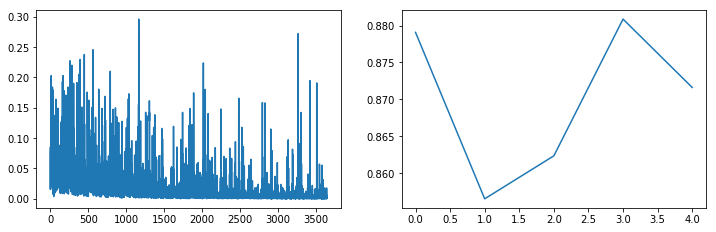

In [20]:
num_epochs = 5
train_losses = []
valid_accs = []
best_acc = 0
PATH = './best_model_{}.pt'

for epoch in range(num_epochs):
    for t, sample in enumerate(image_dataloader_train):
        model.train()
        x_var = Variable(sample['image'].cuda())
        y_var = Variable(sample['Label'].cuda().long())
        
        x_var = resnet18(x_var)
        #x_var = resnet34(x_var)
        scores = model(x_var)
        loss = loss_fn(scores, y_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    num_correct = 0
    num_samples = 0
    for t, sample in enumerate(image_dataloader_val):
        x_var = Variable(sample['image'].cuda())
        y_var = Variable(sample['Label'].cuda().long())
        
        x_var = resnet18(x_var)
        #x_var = resnet34(x_var)
        scores = model(x_var)
        
        _, preds = scores.data.cpu().max(1)
        y_var = y_var.cpu()
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    
    acc = float(num_correct)/num_samples
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)))
    
    valid_accs.append(acc)
    clear_output(True)
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.plot(train_losses)
    plt.subplot(222)
    plt.plot(valid_accs)
    plt.show()

In [31]:
PATH = './best_model_{}.pt'
PATH.format(str(0.88))

'./best_model_0.88.pt'

In [15]:
model_load = torch.load('best_model_0.8878923766816144.pt')
model_load.eval()

Sequential(
  (0): Linear(in_features=1000, out_features=1000, bias=True)
  (1): ReLU(inplace)
  (2): Linear(in_features=1000, out_features=10, bias=True)
)

In [18]:
check_accuracy_2(model_load, image_dataloader_val)

Got 5940 / 6690 correct (88.79)


In [17]:
def check_accuracy_2(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'].cuda())
        y_var = sample['Label'].cuda()
        
        x_var = resnet34(x_var)
        scores = model(x_var)
        y_var=y_var.cpu()
        _, preds = scores.data.cpu().max(1)

        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [19]:
def predict_on_test(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image']).cuda()
        x_var = resnet34(x_var)
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(int(preds[i]))+'\n')
            count+=1
    results.close()
    return count

predict_on_test(model_load, image_dataloader_test)

9810

---

---

### 3D Convolution on video clips (25 points+10 extra points)
3D convolution is for videos, it has one more dimension than 2d convolution. You can find the document for 3D convolution here http://pytorch.org/docs/master/nn.html#torch.nn.Conv3dIn. In our dataset, each clip is a video of 3 frames. Lets classify the each clip rather than each image using 3D convolution.
We offer the data loader, the train_3d and check_accuracy

In [24]:
class ActionClipDataset(Dataset):
    """Action Landmarks dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
        folder=idx+1
        folder=format(folder,'05d')
        clip=[]
        if len(self.labels)!=0:
            Label=self.labels[idx][0]-1
        for i in range(3):
            imidx=i+1
            imgname=str(imidx)+'.jpg'
            img_path = os.path.join(self.root_dir,
                                    folder,imgname)
            image = Image.open(img_path)
            image=np.array(image)
            clip.append(image)
        if self.transform:
            clip=np.asarray(clip)
            clip=np.transpose(clip, (0,3,1,2))
            clip = torch.from_numpy(np.asarray(clip))
        if len(self.labels)!=0:
            sample={'clip':clip,'Label':Label,'folder':folder}
        else:
            sample={'clip':clip,'folder':folder}
        return sample

clip_dataset=ActionClipDataset(root_dir='./data/trainClips/', labels=label_train,transform=T.ToTensor())#/home/tqvinh/Study/CSE512/cse512-s18/hw2data/trainClips/
for i in range(5):
    sample=clip_dataset[i]
    print(sample['clip'].shape)
    print(sample['Label'])
    print(sample['folder'])

torch.Size([3, 3, 64, 64])
0.0
00001
torch.Size([3, 3, 64, 64])
0.0
00002
torch.Size([3, 3, 64, 64])
0.0
00003
torch.Size([3, 3, 64, 64])
0.0
00004
torch.Size([3, 3, 64, 64])
0.0
00005


In [255]:
def train_3d(model, loss_fn, optimizer,dataloader,num_epochs = 1):
    for epoch in range(num_epochs):
        print('Startbing epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['clip'].type(dtype))
            y_var = Variable(sample['Label'].type(dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        check_accuracy_3d(model, clip_dataloader_train) 
        check_accuracy_3d(model, clip_dataloader_val) 
        torch.save(model.state_dict(), os.path.join('./', 'epoch-{}.pth'.format(epoch)))
        

def check_accuracy_3d(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['clip'].type(dtype))
        y_var = sample['Label'].type(dtype)
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))


torch.Size([3, 3, 64, 64])
0.0
00001


In [25]:
clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=T.ToTensor())
clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=16,shuffle=True, num_workers=4)

clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())
clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=16, shuffle=True, num_workers=4)

clip_dataset_test=ActionClipDataset(root_dir='./data/testClips/',labels=[],transform=T.ToTensor())
clip_dataloader_test = DataLoader(clip_dataset_test, batch_size=16, shuffle=False, num_workers=4)

Write the Flatten for 3d covolution feature maps.

In [26]:
class Flatten3d(nn.Module):
    def forward(self, x):
        ###############6th TODO (5 points)###################
        N, _, _, _, _ = x.size()  # N is the batch number
        return x.view(N, -1)      # flatten to 1D feature vector

Design a network using 3D convolution on videos for video classification.

In [35]:
fixed_model_3d = nn.Sequential( # You fill this in!
    ###############7th TODO (20 points)#########################
    # Layer 1
    nn.Conv3d(3, 16, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(16),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    # Layer 2
    nn.Conv3d(16, 32, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(32),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    # Layer 3
    nn.Conv3d(32, 64, kernel_size=(2, 3, 3), padding=0),
    nn.BatchNorm3d(64),
    nn.LeakyReLU(),
    nn.Conv3d(64, 64, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(64),
    nn.LeakyReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    # Classification
    Flatten3d(),
    nn.ReLU(),
    nn.BatchNorm1d(32768),
    nn.Linear(32768, 10)
)

dtype = torch.FloatTensor
fixed_model_3d = fixed_model_3d.type(dtype)
x = torch.randn(32,3, 3, 64, 64).type(dtype)
x_var = Variable(x).type(dtype) # Construct a PyTorch Variable out of your input data
ans = fixed_model_3d(x_var) 
np.array_equal(np.array(ans.size()), np.array([32, 10]))

gpu_dtype = torch.cuda.FloatTensor

fixed_model_3d_gpu = copy.deepcopy(fixed_model_3d)#.type(gpu_dtype)
fixed_model_3d_gpu.cuda()
x_gpu = torch.randn(32,3,3,64,64).cuda()#.type(gpu_dtype)
x_var_gpu = Variable(x_gpu).type(gpu_dtype) # Construct a PyTorch Variable out of your input data
ans = fixed_model_3d_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([32, 10]))

True

### Describe what you did (5 points)

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

### 8th TODO Tell us here:

In [36]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(fixed_model_3d.parameters(), weight_decay=0.5, lr=1e-4)

In [37]:
def train_3d(model, loss_fn, optimizer,dataloader,num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['clip'].cuda())
            y_var = Variable(sample['Label'].cuda().long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy_3d(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['clip'].cuda())
        y_var = sample['Label'].cuda()
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [39]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [40]:
torch.cuda.random.manual_seed(12345)
fixed_model_3d_gpu.apply(reset) 
fixed_model_3d_gpu.train() 
train_3d(fixed_model_3d_gpu, loss_fn, optimizer, clip_dataloader_train, num_epochs=1) 
fixed_model_3d_gpu.eval() 
check_accuracy_3d(fixed_model_3d_gpu, clip_dataloader_train)
check_accuracy_3d(fixed_model_3d_gpu, clip_dataloader_val)

Starting epoch 1 / 1


RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

Test your 3d convolution model on the validation set. You don't need to submit the result of this part to kaggle.  

Test your model on the test set, predict_on_test_3d() will generate a file named 'results_3d.csv'. Please submit the csv file to kaggle https://www.kaggle.com/c/cse512springhw3video
The highest 3 entries get extra 10 points.


In [129]:
def predict_on_test_3d(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results_3d.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['clip'].cuda())
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(int(preds[i]))+'\n')
            count+=1
    results.close()
    return count
    
count=predict_on_test_3d(fixed_model_gpu, clip_dataloader_test)
print(count)

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same